# Rpeak

This example shows how to use the ‍‍‍`RpeakData‍‍‍` class to make a dataset. This class is similar to the `RhythmData` class. However, unlike the `RhythmData` class, it does not provide only one label for each excerpt. Instead, it provides a list of labels for each excerpt. Each element in this annotation list corresponds to a subsegment of the excerpt. The `ECGSequence` class uses the created dataset to generate batches of sample data.

This example is availble on [GitHub](https://github.com/devnums/pyheartlib/blob/main/examples/).

<a target="_blank" href="https://colab.research.google.com/github/devnums/pyheartlib/blob/main/examples/dataset/rpeak.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install pyheartlib

First, `pyheartlib` needs to be installed.

In [1]:
try:
    import pyheartlib
    print(f'Pyheartlib version {pyheartlib.__version__} is already installed!')
except ModuleNotFoundError:
    print('Installing pyheartlib...')
    %pip install pyheartlib
    import pyheartlib
    print(f'Pyheartlib version {pyheartlib.__version__} is installed!')

Pyheartlib version 1.21.0 is already installed!


## Download raw data

`Pyheartlib` supports the WFDB format. A popular dataset that uses this format is the "MIT-BIH Arrhythmia Database". The code below downloads this dataset and stores it in the data directory.

In [29]:
# Download the raw data and store them in the base data directory
from pathlib import Path
if not Path('data').is_dir():
  print('downloading raw data...')
  import io, zipfile
  from urllib.request import urlopen
  url='https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip'
  with urlopen(url) as rs:
      zipf = zipfile.ZipFile(io.BytesIO(rs.read()))
      zipf.extractall('data/')

  # Create the config file. For this example, it will be download from the original repository
  with urlopen("https://raw.githubusercontent.com/devnums/pyheartlib/main/src/pyheartlib/config.yaml") as file:
      content = file.read().decode()
  with open("data/config.yaml", 'w') as file:
      file.write(content)

## Create dataset

To create a dataset using the `RpeakData`, first it needs to be imported.
```python
from pyheartlib.data_rpeak import RpeakData
```

The next step is to create an object of the `pyheartlib.data_rpeak.RpeakData`. 

```python
rpeak_data = RpeakData(
    base_path="data", remove_bl=False, lowpass=False, progress_bar=False
)
```
Descriptions of all the parameters can be found [here](../introduction.html#directive-rpd).

Using the `save_dataset()` method, the dataset will be created.

```python
rpeak_data.save_dataset(
    rec_list=train_set,
    file_name="train.rpeak",
    win_size=5 * 360,
    stride=360,
    interval=72,
)
```

Let's create the dataset by running the next code block.

In [30]:
import numpy as np
import pandas as pd
from pyheartlib.data_rpeak import RpeakData

# Make an instance of the RpeakData
rpeak_data = RpeakData(
    base_path="data", remove_bl=False, lowpass=False, progress_bar=False
)

# Define records
train_set = [201, 203]

# Create the dataset
# The win_size specifies the length of the excerpts
rpeak_data.save_dataset(
    rec_list=train_set,
    file_name="train.rpeak",
    win_size=5 * 360,
    stride=360,
    interval=72,
)


File saved at: data/train.rpeak


Now that the dataset is ready, it can be loaded using the `load_dataset()` function.
```python
from pyheartlib.data_rpeak import load_dataset
annotated_records, samples_info = load_dataset("data/train.rpeak")
```

Let's load the data and count the number of samples for each class.

In [31]:
# Load the dataset
from pyheartlib.data_rpeak import load_dataset
annotated_records, samples_info = load_dataset("data/train.rpeak")

labels = []
for sample in samples_info:
    labels.append(sample[3])
df = pd.DataFrame(np.unique(labels, return_counts=True), index=["Label", "Count"])
print(df)

File loaded from: data/train.rpeak
           0    1   2  3      4   5     6    7   8
Label      0    A   F  J      N   Q     V    a   j
Count  65388  150  15  5  20718  20  3210  494  50


The metadata of a sample is a list: [record ID, onset, offset, annotation]

In [32]:
# Metadata of a sample excerpt
# [record ID, onset, offset, annotation]
print(samples_info[102])

[0, 36720, 38520, [0, 0, 0, 0, 'N', 0, 'N', 0, 'N', 0, 0, 0, 'N', 0, 0, 'N', 0, 0, 'N', 0, 0, 0, 'N', 0, 0]]


## Generate data samples

In this section, the dataset that was created in the previous section will be used to generate batches of sample data. To accomplish this, an instance of `pyheartlib.data_rpeak.ECGSequence` must be created.
```python
from pyheartlib.data_rpeak import ECGSequence

ecgseq = ECGSequence(
    annotated_records, samples_info, binary=False, batch_size=2, raw=True, interval=72
)
```

The `ECGSequence` takes the  *annotated_records* (ECG records) and the *samples_info* (metadata) that were loaded previously.

Other parameters that `ECGSequence` takes can be found [here](../introduction.html#directive-rps).

Let's generate a batch of data and examine the shapes and values of the samples.

In [33]:
# Generate data in batch using he ECGSequence

# Returns a tuple containing two elements when its object is utilized in
# this way: ECGSequence_object[BatchNo].

# The first element (Batch_x) contains data samples and the
# second one (Batch_y) their associated annotation.

# Batch_x contains the signal excerpts or their features (Batch_wave).

# If `raw` is False, Batch_wave has the shape of
# (Batch size, Number of channels, Number of sub-segments, Number of features), 
# otherwise, it has the shape of (Batch_size, Number of channels, Length of excerpt).

# Batch_y has the shape of (Batch size, Length of annotation list).

from pyheartlib.data_rpeak import ECGSequence

ecgseq = ECGSequence(
    annotated_records, samples_info, binary=False, batch_size=3, raw=True, interval=72
)
bt = 0  # Batch number
batch_x, batch_y = ecgseq[bt]
batch_annotation = batch_y  # Annotation
batch_wave = batch_x  # Excerpt

print("Length of annotation for each sample data:", len(batch_annotation[0]))
print("Length of each sample excerpt:", batch_wave.shape[2])
print("Batch_wave shape:", batch_wave.shape, ", Batch_annotation shape:", batch_annotation.shape)


Length of annotation for each sample data: 25
Length of each sample excerpt: 1800
Batch_wave shape: (3, 2, 1800) , Batch_annotation shape: (3, 25)


In [34]:
# Annotations of the samples in the batch
print(batch_annotation)

[['N' '0' '0' 'N' '0' 'N' '0' '0' 'N' '0' 'N' '0' '0' '0' 'N' '0' '0' 'N'
  '0' 'N' '0' '0' 'N' '0' 'N']
 ['0' 'V' '0' '0' 'N' '0' '0' '0' 'N' '0' '0' 'N' '0' 'N' '0' '0' 'N' '0'
  'V' '0' '0' 'N' '0' '0' '0']
 ['0' '0' 'N' '0' '0' '0' '0' 'N' '0' '0' '0' '0' '0' 'N' '0' '0' '0' '0'
  '0' 'N' '0' '0' '0' '0' '0']]


Length of each excerpt: 1800


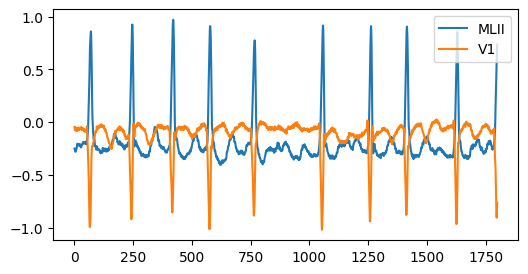

In [35]:
# Plot an output excerpt of the batch
wf = batch_wave[0]
wf_ch1 = wf[0]
wf_ch2 = wf[1]
print(f'Length of each excerpt: {len(wf_ch1)}')

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
plt.plot(wf_ch1);
plt.plot(wf_ch2);
chs = rpeak_data.config["CHANNEL"]
plt.legend([chs[0], chs[1]], loc="upper right");

The code below generates a batch with the `raw` parameter set to *False*. In this case, the generated batch contains computed features instead of raw waveform.

In [36]:
# When raw is set to False
ecgseq = ECGSequence(
    annotated_records, samples_info, binary=False, batch_size=3, raw=False, interval=72
)

bt = 0  # Batch number
batch_x, batch_y = ecgseq[bt]
batch_annotation = batch_y  # Annotation
batch_wave = batch_x  # Excerpt

print("Length of annotation for each sample data:", len(batch_annotation[0]))
print("Batch_wave shape:", batch_wave.shape, ", Batch_annotation shape:", batch_annotation.shape)


Length of annotation for each sample data: 25
Batch_wave shape: (3, 2, 25, 14) , Batch_annotation shape: (3, 25)
